# Portfolio performance (PnL)
## 1. Parametric model in name space

In [1]:
import os, sys, copy, h5py, datetime, tqdm, gc, pickle
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import multiprocessing
from joblib import Parallel, delayed

if __name__ == "__main__":
    sys.path.append(os.path.join(os.getcwd(), '../..'))
import data.data as data
import market_decomposition.market_factor_classic as factor
import trading_signal.trading_signal as trading_signal
import utils.utils as utils

QUICK_TEST = False
PCA_TYPE = "name"; factor_name = "PCA_name"
#PCA_TYPE = "rank_hybrid_Atlas"; factor_name = "PCA_rank_hybrid_Atlas"
#PCA_TYPE = "rank_hybrid_Atlas_high_freq"; factor_name = "PCA_rank_hybrid_Atlas_high_freq"
#PCA_TYPE = "rank_permutation"; factor_name = "PCA_rank_permutation"
#PCA_TYPE = "rank_theta_transform"; factor_name = "PCA_rank_theta"

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
color_dict = {"PCA_name": color_cycle[0], "PCA_rank_permutation": color_cycle[1], "PCA_rank_hybrid_Atlas": color_cycle[2], 
              "PCA_rank_hybrid_Atlas_high_freq": color_cycle[3], "PCA_rank_theta": color_cycle[4]}

t_eval_start = datetime.datetime(1991,1,1); t_eval_end = datetime.datetime(2022,12,15)

t_eval_start_list = [datetime.datetime(1991,1,1), datetime.datetime(1996,1,1), datetime.datetime(2001,1,1), datetime.datetime(2006,1,1), datetime.datetime(2011,1,1), datetime.datetime(2016,1,1)]
t_eval_end_list = [datetime.datetime(1995,12,31), datetime.datetime(2000,12,31), datetime.datetime(2005,12,31), datetime.datetime(2010,12,31), datetime.datetime(2015,12,31), datetime.datetime(2022,12,15)]
equity_data_config = {"Fama_French_3factor_file_name": os.path.join(os.getcwd(), "../../data/equity_data/Fama_French_3factor_19700101_20221231.csv"),
            "Fama_French_5factor_file_name": os.path.join(os.getcwd(), "../../data/equity_data/Fama_French_5factor_19700101_20221231.csv"),
            "equity_file_name":  os.path.join(os.getcwd(), "../../data/equity_data/equity_data_19700101_20221231.csv"),
            "filter_by_return_threshold": 3,
            "SPX_file_name": os.path.join(os.getcwd(), "../../data/equity_data/SPX_19700101_20221231.csv"),
            "Russel2000_file_name": os.path.join(os.getcwd(), "../../data/equity_data/Russel2000_19879010_20231024.csv"),
            "Russel3000_file_name": os.path.join(os.getcwd(), "../../data/equity_data/Russel3000_19879010_20231110.csv"),
            "macroeconomics_124_factor_file_name": os.path.join(os.getcwd(), "../../data/equity_data/macroeconomics_124_factor_19700101_20221231.csv")}
equity_data_ = data.equity_data(equity_data_config)

equity_data_high_freq_config = {}
equity_data_high_freq_ = data.equity_data_high_freq(equity_data_high_freq_config)

if PCA_TYPE == "name":
    data_ = pd.read_csv(os.path.join(os.getcwd(), "../../data/equity_data/equity_idx_PERMNO_ticker.csv"))
    ticker = list(data_.iloc[:, 2])
    del data_

time_tick_label = ["1991/1/1", "1996/1/1", "2001/1/1", "2006/1/1", "2011/1/1", "2016/1/1", "2022/12/15"]
time_tick_idx = [np.searchsorted(equity_data_.time_axis, datetime.datetime.strptime(t, "%Y/%m/%d")) for t in time_tick_label]
time_tick_idx = np.array(time_tick_idx) - time_tick_idx[0]

PCA_factor_config = {"factor_evaluation_window_length": 252,
                "loading_evaluation_window_length": 60, 
                "residual_return_evaluation_window_length": 60,
                "rank_min": 0,
                "rank_max": 999,
                "factor_number": 3,
                "type": PCA_TYPE,
                "max_cache_len": 100,
                "quick_test": QUICK_TEST}
PCA_factor_ = factor.PCA_factor(equity_data_, equity_data_high_freq_, PCA_factor_config)
PCA_factor_._initialize_residual_return_all()


Initialize data loader complete.
Initialize data loader (high frequency) complete.
Initialize PCA factor name complete.


100%|██████████| 4018/4018 [00:39<00:00, 101.93it/s]


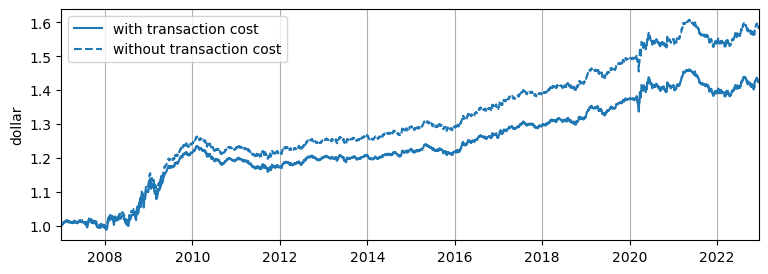

In [2]:
transaction_cost_factor = 0.0002; shorting_cost_factor = 0.0000; leverage = 1
#t_eval_start = datetime.datetime(1991,1,1); t_eval_end = datetime.datetime(2022,12,15)
t_eval_start = datetime.datetime(2007,1,1); t_eval_end = datetime.datetime(2022,12,15)

file_name = os.path.join(os.getcwd(), "../../results/portfolio_performance_{}-OU_process-OU_process.npz".format(factor_name))
result = np.load(file_name, allow_pickle=True)

if PCA_TYPE == "name":
    time_axis = [datetime.datetime.fromtimestamp(j) for j in result["time"]]
    portfolio_weights_epsilon = result["portfolio_weights_epsilon"]; portfolio_weights_R = result["portfolio_weights_R"]
    t_idx = np.arange(np.searchsorted(time_axis, t_eval_start), np.searchsorted(time_axis, t_eval_end)+1, 1)
    time_axis = [time_axis[j] for j in t_idx]; portfolio_weights_epsilon = portfolio_weights_epsilon[:, t_idx]; portfolio_weights_R = portfolio_weights_R[:, t_idx]
    portfolio_weights_R = list(portfolio_weights_R.T)
    equity_idx = []
    for j in range(len(portfolio_weights_R)):
        equity_idx.append(np.where(np.abs(portfolio_weights_R[j]) > 1e-8)[0])
    plt.figure(figsize=(9, 3))
    result = utils.evaluate_PnL_name_space(equity_data_, time_axis, equity_idx, portfolio_weights_R, leverage=leverage, transaction_cost_factor=transaction_cost_factor, shorting_cost_factor=shorting_cost_factor, is_vanilla=False)
    time_axis_PnL = result["time_hist"]; asset_hist = np.array(result["asset_hist"]); return_hist = np.array(result["return_hist"]); transaction_cost_hist = np.array(result["transaction_cost_hist"])
    sharp_ratio_summary = []
    year_start = t_eval_start.year; year_end = t_eval_end.year
    for year in np.arange(year_start, year_end+1, 1):
        idx = np.where([j.year == year for j in time_axis_PnL])[0]
        return_annual = np.power(asset_hist[idx[-1]]/asset_hist[idx[0]], 252/(len(idx)-1))-1
        vol_annual = np.nanstd(return_hist[idx])*np.sqrt(252)
        sharp_ratio = return_annual/vol_annual
        sharp_ratio_summary.append([year, return_annual, vol_annual, sharp_ratio])

    plt.plot(time_axis_PnL, asset_hist, label="with transaction cost", color=color_dict["PCA_name"])
    #plt.plot(time_axis_PnL, np.cumsum(transaction_cost_hist), label="cumulative transaction cost", color="gray", alpha=0.5)
    time_axis_PnL_timestamp = [j.timestamp() for j in time_axis_PnL]
    np.savez(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_with_transaction_cost.npz".format(factor_name)), 
            time_hist=time_axis_PnL_timestamp, asset_hist=asset_hist, return_hist=return_hist, transaction_cost_hist=transaction_cost_hist)
    df = pd.DataFrame(np.array(sharp_ratio_summary), columns=["year", "return_annual", "vol_annual", "sharp_ratio"])
    df.to_csv(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_with_transaction_cost.csv".format(factor_name)))

    result = utils.evaluate_PnL_name_space(equity_data_, time_axis, equity_idx, portfolio_weights_R, leverage=leverage, transaction_cost_factor=0, shorting_cost_factor=0, is_vanilla=False)
    time_axis_PnL = result["time_hist"]; asset_hist = np.array(result["asset_hist"]); return_hist = np.array(result["return_hist"]); transaction_cost_hist = np.array(result["transaction_cost_hist"])
    sharp_ratio_summary = []
    year_start = t_eval_start.year; year_end = t_eval_end.year
    for year in np.arange(year_start, year_end+1, 1):
        idx = np.where([j.year == year for j in time_axis_PnL])[0]
        return_annual = np.power(asset_hist[idx[-1]]/asset_hist[idx[0]], 252/(len(idx)-1))-1
        vol_annual = np.nanstd(return_hist[idx])*np.sqrt(252)
        sharp_ratio = return_annual/vol_annual
        sharp_ratio_summary.append([year, return_annual, vol_annual, sharp_ratio])

    plt.plot(time_axis_PnL, asset_hist, label="without transaction cost", color=color_dict["PCA_name"], linestyle="--")
    plt.ylabel("dollar"); plt.grid(axis="x"); plt.legend(); plt.xlim([time_axis_PnL[0], time_axis_PnL[-1]])
    #plt.title("PnL: {}-OU_process-OU_process".format(factor_name))
    plt.savefig(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process.pdf".format(factor_name)))
    time_axis_PnL_timestamp = [j.timestamp() for j in time_axis_PnL]
    np.savez(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_without_transaction_cost.npz".format(factor_name)),
            time_hist=time_axis_PnL_timestamp, asset_hist=asset_hist, return_hist=return_hist, transaction_cost_hist=transaction_cost_hist)
    df = pd.DataFrame(np.array(sharp_ratio_summary), columns=["year", "return_annual", "vol_annual", "sharp_ratio"])
    df.to_csv(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_without_transaction_cost.csv".format(factor_name)))


## 2. Neural networks in name space

100%|██████████| 4018/4018 [00:38<00:00, 103.18it/s]


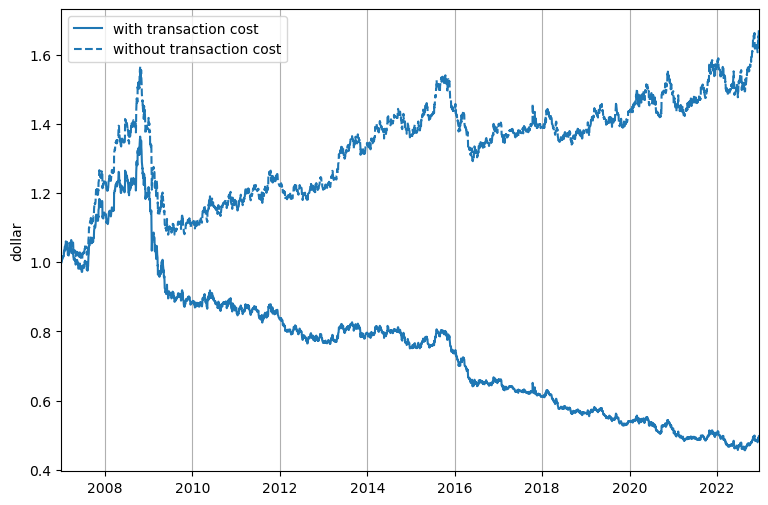

In [7]:
PCA_TYPE = "name"; factor_name = "PCA_name"

transaction_cost_factor = 0.0002; shorting_cost_factor = 0.0000; leverage = 1
t_eval_start = datetime.datetime(2007,1,1); t_eval_end = datetime.datetime(2022,12,15)
#t_eval_start = datetime.datetime(2005,4,5); t_eval_end = datetime.datetime(2012, 12, 31) # quarterly update
#t_eval_start = datetime.datetime(2006, 1, 3); t_eval_end = datetime.datetime(2012, 12, 31) # annual update

file_name = os.path.join(os.getcwd(), "../../results/portfolio_performance_{}-CNN_transformer.npz".format(factor_name))
result = np.load(file_name, allow_pickle=True)

if PCA_TYPE == "name":
    time_axis = [datetime.datetime.fromtimestamp(j) for j in result["time"]]
    portfolio_weights_epsilon = result["portfolio_weights_epsilon"]; portfolio_weights_R = result["portfolio_weights_R"]
    t_idx = np.arange(np.searchsorted(time_axis, t_eval_start), np.searchsorted(time_axis, t_eval_end)+1, 1)
    time_axis = [time_axis[j] for j in t_idx]; portfolio_weights_epsilon = portfolio_weights_epsilon[:, t_idx]; portfolio_weights_R = portfolio_weights_R[:, t_idx]
    portfolio_weights_R = list(portfolio_weights_R.T)
    equity_idx = []
    for j in range(len(portfolio_weights_R)):
        equity_idx.append(np.where(np.abs(portfolio_weights_R[j]) > 1e-8)[0])
    plt.figure(figsize=(9, 6))
    result = utils.evaluate_PnL_name_space(equity_data_, time_axis, equity_idx, portfolio_weights_R, leverage=leverage, transaction_cost_factor=transaction_cost_factor, shorting_cost_factor=shorting_cost_factor, is_vanilla=False)
    time_axis_PnL = result["time_hist"]; asset_hist = result["asset_hist"]
    return_hist = np.array(result["return_hist"]); transaction_cost_hist = result["transaction_cost_hist"]
    sharp_ratio_summary = []
    year_start = t_eval_start.year; year_end = t_eval_end.year
    for year in np.arange(year_start, year_end+1, 1):
        idx = np.where([j.year == year for j in time_axis_PnL])[0]
        return_annual = np.power(asset_hist[idx[-1]]/asset_hist[idx[0]], 252/(len(idx)-1))-1
        vol_annual = np.nanstd(return_hist[idx])*np.sqrt(252)
        sharp_ratio = return_annual/vol_annual
        sharp_ratio_summary.append([year, return_annual, vol_annual, sharp_ratio])

    #plt.subplot(2, 1, 1)
    plt.plot(time_axis_PnL, asset_hist, label="with transaction cost", color=color_dict[factor_name])
    #plt.plot(time_axis_PnL, np.cumsum(transaction_cost_hist), label="cumulative transaction cost", color="gray", alpha=0.5)
    time_axis_PnL_timestamp = [j.timestamp() for j in time_axis_PnL]
    np.savez(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_with_transaction_cost.npz".format(factor_name)),
            time_hist=time_axis_PnL_timestamp, asset_hist=asset_hist, return_hist=return_hist, transaction_cost_hist=transaction_cost_hist)
    '''
    plt.subplot(2, 1, 2)
    df = pd.DataFrame(np.array(sharp_ratio_summary), columns=["year", "return_annual", "vol_annual", "sharp_ratio"])
    plt.plot(df["year"], df["sharp_ratio"], marker="o", label="with transaction cost", color=color_dict[factor_name])
    df.to_csv(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_with_transaction_cost.csv".format(factor_name)))
    '''

    result = utils.evaluate_PnL_name_space(equity_data_, time_axis, equity_idx, portfolio_weights_R, leverage=leverage, transaction_cost_factor=0, shorting_cost_factor=0, is_vanilla=False)
    time_axis_PnL = result["time_hist"]; asset_hist = result["asset_hist"]
    return_hist = np.array(result["return_hist"]); transaction_cost_hist = result["transaction_cost_hist"]
    sharp_ratio_summary = []
    year_start = t_eval_start.year; year_end = t_eval_end.year
    for year in np.arange(year_start, year_end+1, 1):
        idx = np.where([j.year == year for j in time_axis_PnL])[0]
        return_annual = np.power(asset_hist[idx[-1]]/asset_hist[idx[0]], 252/(len(idx)-1))-1
        vol_annual = np.nanstd(return_hist[idx])*np.sqrt(252)
        sharp_ratio = return_annual/vol_annual
        sharp_ratio_summary.append([year, return_annual, vol_annual, sharp_ratio])
    #plt.subplot(2, 1, 1)
    plt.plot(time_axis_PnL, asset_hist, label="without transaction cost", color=color_dict[factor_name], linestyle="--")
    plt.ylabel("dollar"); plt.grid(axis="x"); plt.legend(); plt.xlim([time_axis_PnL[0], time_axis_PnL[-1]])
    time_axis_PnL_timestamp = [j.timestamp() for j in time_axis_PnL]
    np.savez(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.npz".format(factor_name)),
            time_hist=time_axis_PnL_timestamp, asset_hist=asset_hist, return_hist=return_hist, transaction_cost_hist=transaction_cost_hist)
    df = pd.DataFrame(np.array(sharp_ratio_summary), columns=["year", "return_annual", "vol_annual", "sharp_ratio"])
    df.to_csv(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.csv".format(factor_name)))
    '''
    plt.subplot(2, 1, 2)
    plt.plot(df["year"], df["sharp_ratio"], marker="o", label="without transaction cost", color=color_dict[factor_name], linestyle="--")
    plt.ylabel("sharp ratio"); plt.xlabel("year"); plt.grid(axis="x"); plt.legend()
    plt.savefig(os.path.join(os.getcwd(), "transformer.pdf".format(factor_name)))
    '''


## 3. Parametric model in rank space


In [8]:
QUICK_TEST = False
#PCA_TYPE = "name"; factor_name = "PCA_name"
#PCA_TYPE = "rank_hybrid_Atlas"; factor_name = "PCA_rank_hybrid_Atlas"
PCA_TYPE = "rank_hybrid_Atlas_high_freq"; factor_name = "PCA_rank_hybrid_Atlas_high_freq"
#PCA_TYPE = "rank_permutation"; factor_name = "PCA_rank_permutation"
#PCA_TYPE = "rank_theta_transform"; factor_name = "PCA_rank_theta"

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
color_dict = {"PCA_name": color_cycle[0], "PCA_rank_permutation": color_cycle[1], "PCA_rank_hybrid_Atlas": color_cycle[2], 
              "PCA_rank_hybrid_Atlas_high_freq": color_cycle[3], "PCA_rank_theta": color_cycle[4]}

t_eval_start = datetime.datetime(1991,1,1); t_eval_end = datetime.datetime(2022,12,15)

t_eval_start_list = [datetime.datetime(1991,1,1), datetime.datetime(1996,1,1), datetime.datetime(2001,1,1), datetime.datetime(2006,1,1), datetime.datetime(2011,1,1), datetime.datetime(2016,1,1)]
t_eval_end_list = [datetime.datetime(1995,12,31), datetime.datetime(2000,12,31), datetime.datetime(2005,12,31), datetime.datetime(2010,12,31), datetime.datetime(2015,12,31), datetime.datetime(2022,12,15)]
equity_data_config = {"Fama_French_3factor_file_name": os.path.join(os.getcwd(), "../../data/equity_data/Fama_French_3factor_19700101_20221231.csv"),
            "Fama_French_5factor_file_name": os.path.join(os.getcwd(), "../../data/equity_data/Fama_French_5factor_19700101_20221231.csv"),
            "equity_file_name":  os.path.join(os.getcwd(), "../../data/equity_data/equity_data_19700101_20221231.csv"),
            "filter_by_return_threshold": 3,
            "SPX_file_name": os.path.join(os.getcwd(), "../../data/equity_data/SPX_19700101_20221231.csv"),
            "Russel2000_file_name": os.path.join(os.getcwd(), "../../data/equity_data/Russel2000_19879010_20231024.csv"),
            "Russel3000_file_name": os.path.join(os.getcwd(), "../../data/equity_data/Russel3000_19879010_20231110.csv"),
            "macroeconomics_124_factor_file_name": os.path.join(os.getcwd(), "../../data/equity_data/macroeconomics_124_factor_19700101_20221231.csv")}
equity_data_ = data.equity_data(equity_data_config)

equity_data_high_freq_config = {}
equity_data_high_freq_ = data.equity_data_high_freq(equity_data_high_freq_config)

if PCA_TYPE == "name":
    data_ = pd.read_csv(os.path.join(os.getcwd(), "../../data/equity_data/equity_idx_PERMNO_ticker.csv"))
    ticker = list(data_.iloc[:, 2])
    del data_

time_tick_label = ["1991/1/1", "1996/1/1", "2001/1/1", "2006/1/1", "2011/1/1", "2016/1/1", "2022/12/15"]
time_tick_idx = [np.searchsorted(equity_data_.time_axis, datetime.datetime.strptime(t, "%Y/%m/%d")) for t in time_tick_label]
time_tick_idx = np.array(time_tick_idx) - time_tick_idx[0]

PCA_factor_config = {"factor_evaluation_window_length": 252,
                "loading_evaluation_window_length": 60, 
                "residual_return_evaluation_window_length": 60,
                "rank_min": 0,
                "rank_max": 999,
                "factor_number": 3,
                "type": PCA_TYPE,
                "max_cache_len": 100,
                "quick_test": QUICK_TEST}
PCA_factor_ = factor.PCA_factor(equity_data_, equity_data_high_freq_, PCA_factor_config)
PCA_factor_._initialize_residual_return_all()


Initialize data loader complete.
Initialize data loader (high frequency) complete.
Initialize PCA factor rank_hybrid_Atlas_high_freq complete.


100%|██████████| 4018/4018 [23:16<00:00,  2.88it/s]


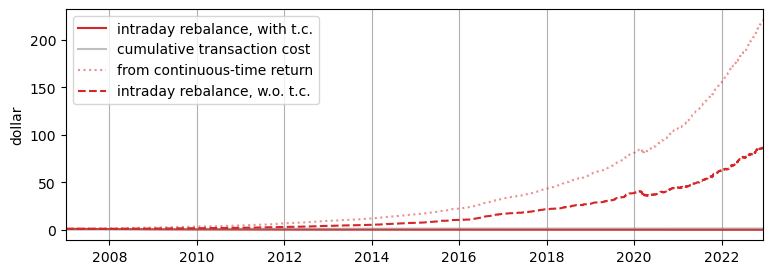

In [ ]:
transaction_cost_factor = 0.0002; shorting_cost_factor = 0.0000; leverage = 1
#t_eval_start = datetime.datetime(1991,1,1); t_eval_end = datetime.datetime(2022,12,15)
t_eval_start = datetime.datetime(2007,1,1); t_eval_end = datetime.datetime(2022,12,15)

file_name = os.path.join(os.getcwd(), "../../results/portfolio_performance_{}-OU_process-OU_process.npz".format(factor_name))
result = np.load(file_name, allow_pickle=True)

if PCA_TYPE == "rank_hybrid_Atlas":
    time_axis = [datetime.datetime.fromtimestamp(j) for j in result["time"]]
    portfolio_weights_epsilon = result["portfolio_weights_epsilon"]; portfolio_weights_R_rank = result["portfolio_weights_R_rank"]
    portfolio_weights_R_name = result["portfolio_weights_R_name"]
    t_idx = np.arange(np.searchsorted(time_axis, t_eval_start), np.searchsorted(time_axis, t_eval_end)+1, 1)
    time_axis = [time_axis[j] for j in t_idx]; portfolio_weights_epsilon = portfolio_weights_epsilon[:, t_idx]; portfolio_weights_R_rank = portfolio_weights_R_rank[:, t_idx]; portfolio_weights_R_name = portfolio_weights_R_name[:, t_idx]
    portfolio_weights_R_rank = list(portfolio_weights_R_rank.T); portfolio_weights_R_name = list(portfolio_weights_R_name.T)
    epsilon_idx = []
    for j in range(len(portfolio_weights_R_rank)):
        epsilon_idx.append(np.where(np.abs(portfolio_weights_R_rank[j]) > 1e-8)[0])
    equity_idx = []
    for j in range(len(portfolio_weights_R_name)):
        equity_idx.append(np.where(np.abs(portfolio_weights_R_name[j]) > 1e-8)[0])
    plt.figure(figsize=(9, 3))
    #result = utils.evaluate_PnL_R_rank_space(equity_data_, time_axis, epsilon_idx, portfolio_weights_R_rank, leverage=1, transaction_cost_factor=0, shorting_cost_factor=0)
    #time_axis_PnL = result["time_hist"]; asset_hist_R_rank = result["asset_hist"]; return_hist = result["return_hist"]
    #plt.plot(time_axis_PnL, asset_hist_R_rank, label="from continuous-time return", linestyle=":", color=color_dict[factor_name])

    result = utils.evaluate_PnL_name_space(equity_data_, time_axis, equity_idx, portfolio_weights_R_name, leverage=leverage, transaction_cost_factor=transaction_cost_factor, shorting_cost_factor=shorting_cost_factor, is_vanilla=False)
    time_axis_PnL = result["time_hist"]; asset_hist = result["asset_hist"]; return_hist = result["return_hist"]; transaction_cost_hist = result["transaction_cost_hist"]
    sharp_ratio_summary = []
    year_start = t_eval_start.year; year_end = t_eval_end.year
    for year in np.arange(year_start, year_end+1, 1):
        idx = np.where([j.year == year for j in time_axis_PnL])[0]
        return_annual = np.power(asset_hist[idx[-1]]/asset_hist[idx[0]], 252/(len(idx)-1))-1
        vol_annual = np.nanstd(return_hist[idx])*np.sqrt(252)
        sharp_ratio = return_annual/vol_annual
        sharp_ratio_summary.append([year, return_annual, vol_annual, sharp_ratio])
    plt.plot(time_axis_PnL, asset_hist, label="with transaction cost", color=color_dict[factor_name])
    plt.plot(time_axis_PnL, np.cumsum(transaction_cost_hist), label="cumulative transaction cost", color="gray", alpha=0.5)
    time_axis_PnL_timestamp = [j.timestamp() for j in time_axis_PnL]
    np.savez(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_with_transaction_cost.npz".format(factor_name)),
            time_hist=time_axis_PnL_timestamp, asset_hist=asset_hist, return_hist=return_hist, transaction_cost_hist=transaction_cost_hist)
    df = pd.DataFrame(np.array(sharp_ratio_summary), columns=["year", "return_annual", "vol_annual", "sharp_ratio"])
    df.to_csv(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_with_transaction_cost.csv".format(factor_name)))

    result = utils.evaluate_PnL_name_space(equity_data_, time_axis, equity_idx, portfolio_weights_R_name, leverage=leverage, transaction_cost_factor=0, shorting_cost_factor=0, is_vanilla=False)
    time_axis_PnL = result["time_hist"]; asset_hist = result["asset_hist"]; return_hist = result["return_hist"]; transaction_cost_hist = result["transaction_cost_hist"]
    sharp_ratio_summary = []
    year_start = t_eval_start.year; year_end = t_eval_end.year
    for year in np.arange(year_start, year_end+1, 1):
        idx = np.where([j.year == year for j in time_axis_PnL])[0]
        return_annual = np.power(asset_hist[idx[-1]]/asset_hist[idx[0]], 252/(len(idx)-1))-1
        vol_annual = np.nanstd(return_hist[idx])*np.sqrt(252)
        sharp_ratio = return_annual/vol_annual
        sharp_ratio_summary.append([year, return_annual, vol_annual, sharp_ratio])

    plt.plot(time_axis_PnL, asset_hist, label="without transaction cost", color=color_dict[factor_name], linestyle="--")
    plt.ylabel("dollar"); plt.grid(axis="x"); plt.legend(); plt.xlim([time_axis_PnL[0], time_axis_PnL[-1]])
    #plt.title("PnL: {}-OU_process-OU_process".format(factor_name))
    plt.savefig(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process.pdf".format(factor_name)))
    df = pd.DataFrame(np.array(sharp_ratio_summary), columns=["year", "return_annual", "vol_annual", "sharp_ratio"])
    df.to_csv(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_without_transaction_cost.csv".format(factor_name)))

if PCA_TYPE == "rank_hybrid_Atlas_high_freq":
    time_axis = [datetime.datetime.fromtimestamp(j) for j in result["time"]]
    portfolio_weights_epsilon = result["portfolio_weights_epsilon"]; portfolio_weights_R_rank = result["portfolio_weights_R_rank"]
    t_idx = np.arange(np.searchsorted(time_axis, t_eval_start), np.searchsorted(time_axis, t_eval_end)+1, 1)
    time_axis = [time_axis[j] for j in t_idx]
    portfolio_weights_epsilon = portfolio_weights_epsilon[:, t_idx]
    portfolio_weights_R_rank = portfolio_weights_R_rank[:, t_idx]
    portfolio_weights_R_rank = list(portfolio_weights_R_rank.T)
    epsilon_idx = []
    for j in range(len(portfolio_weights_R_rank)):
        epsilon_idx.append(np.where(np.abs(portfolio_weights_R_rank[j]) > 1e-8)[0])
    plt.figure(figsize=(9, 3))
    result = utils.evaluate_PnL_name_space_high_freq(equity_data_, equity_data_high_freq_, time_axis, epsilon_idx, portfolio_weights_R_rank, leverage=1, transaction_cost_factor=transaction_cost_factor, shorting_cost_factor=shorting_cost_factor)
    time_axis_PnL = result["time_hist"]; asset_hist_R_rank = result["asset_hist_R_rank"]; asset_hist_R_name = result["asset_hist_R_name"]; transaction_cost_hist = result["transaction_cost_hist"]
    return_hist_R_name = np.array([np.nan]+[asset_hist_R_name[j+1]/asset_hist_R_name[j]-1 for j in range(len(asset_hist_R_name)-1)])
    sharp_ratio_summary = []
    year_start = t_eval_start.year; year_end = t_eval_end.year
    for year in np.arange(year_start, year_end+1, 1):
        idx = np.where([j.year == year for j in time_axis_PnL])[0]
        return_annual = np.power(asset_hist_R_name[idx[-1]]/asset_hist_R_name[idx[0]], 252/(len(idx)-1))-1
        vol_annual = np.nanstd(return_hist_R_name[idx])*np.sqrt(252)
        sharp_ratio = return_annual/vol_annual
        sharp_ratio_summary.append([year, return_annual, vol_annual, sharp_ratio])

    plt.plot(time_axis_PnL, asset_hist_R_name, label="intraday rebalance, with t.c.", color=color_dict[factor_name])
    #plt.plot(time_axis_PnL, np.cumsum(transaction_cost_hist), label="cumulative transaction cost", color="gray", alpha=0.5)
    time_axis_PnL_timestamp = [j.timestamp() for j in time_axis_PnL]
    np.savez(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_with_transaction_cost.npz".format(factor_name)),
            time_hist=time_axis_PnL_timestamp, asset_hist=asset_hist_R_name, return_hist=return_hist_R_name, transaction_cost_hist=transaction_cost_hist)
    df = pd.DataFrame(np.array(sharp_ratio_summary), columns=["year", "return_annual", "vol_annual", "sharp_ratio"])
    df.to_csv(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_with_transaction_cost.csv".format(factor_name)))

    result = utils.evaluate_PnL_name_space_high_freq(equity_data_, equity_data_high_freq_, time_axis, epsilon_idx, portfolio_weights_R_rank, leverage=1, transaction_cost_factor=0, shorting_cost_factor=0)
    time_axis_PnL = result["time_hist"]; asset_hist_R_rank = result["asset_hist_R_rank"]; asset_hist_R_name = result["asset_hist_R_name"]
    return_hist_R_name = np.array([np.nan]+[asset_hist_R_name[j+1]/asset_hist_R_name[j]-1 for j in range(len(asset_hist_R_name)-1)])
    sharp_ratio_summary = []
    year_start = t_eval_start.year; year_end = t_eval_end.year
    for year in np.arange(year_start, year_end+1, 1):
        idx = np.where([j.year == year for j in time_axis_PnL])[0]
        return_annual = np.power(asset_hist_R_name[idx[-1]]/asset_hist_R_name[idx[0]], 252/(len(idx)-1))-1
        vol_annual = np.nanstd(return_hist_R_name[idx])*np.sqrt(252)
        sharp_ratio = return_annual/vol_annual
        sharp_ratio_summary.append([year, return_annual, vol_annual, sharp_ratio])

    plt.plot(time_axis_PnL, asset_hist_R_rank, label="from continuous-time return", linestyle=":", color=color_dict[factor_name], alpha=0.5)
    plt.plot(time_axis_PnL, asset_hist_R_name, label="intraday rebalance, w.o. t.c.", linestyle="--", color=color_dict[factor_name])
    plt.ylabel("dollar"); plt.grid(axis="x"); plt.legend(); plt.xlim([time_axis_PnL[0], time_axis_PnL[-1]])
    #plt.title("PnL: {}-OU_process-OU_process".format(factor_name))
    plt.savefig(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process.pdf".format(factor_name)))
    time_axis_PnL_timestamp = [j.timestamp() for j in time_axis_PnL]
    np.savez(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_without_transaction_cost.npz".format(factor_name)),
            time_hist=time_axis_PnL_timestamp, asset_hist=asset_hist_R_name, return_hist=return_hist_R_name)
    df = pd.DataFrame(np.array(sharp_ratio_summary), columns=["year", "return_annual", "vol_annual", "sharp_ratio"])
    df.to_csv(os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_without_transaction_cost.csv".format(factor_name)))



## 4. Neural networks in rank space


100%|██████████| 4018/4018 [21:06<00:00,  3.17it/s]


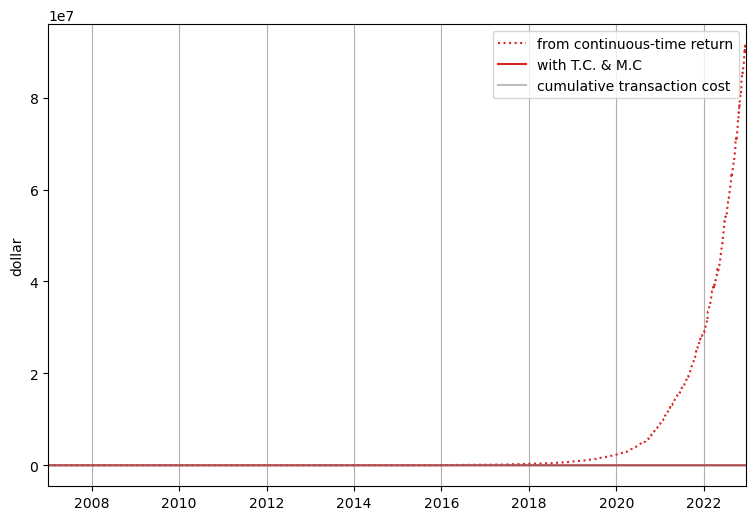

In [10]:
PCA_TYPE = "rank_hybrid_Atlas_high_freq"; factor_name = "PCA_rank_hybrid_Atlas_high_freq"

transaction_cost_factor = 0.0002; shorting_cost_factor = 0.0000; leverage = 1
t_eval_start = datetime.datetime(2007,1,1); t_eval_end = datetime.datetime(2022,12,15)
#t_eval_start = datetime.datetime(2005,4,5); t_eval_end = datetime.datetime(2012, 12, 31) # quarterly update
#t_eval_start = datetime.datetime(2006, 1, 3); t_eval_end = datetime.datetime(2012, 12, 31) # annual update

file_name = os.path.join(os.getcwd(), "../../results/portfolio_performance_{}-CNN_transformer.npz".format(factor_name))
result = np.load(file_name, allow_pickle=True)

if PCA_TYPE == "name":
    time_axis = [datetime.datetime.fromtimestamp(j) for j in result["time"]]
    portfolio_weights_epsilon = result["portfolio_weights_epsilon"]; portfolio_weights_R = result["portfolio_weights_R"]
    t_idx = np.arange(np.searchsorted(time_axis, t_eval_start), np.searchsorted(time_axis, t_eval_end)+1, 1)
    time_axis = [time_axis[j] for j in t_idx]; portfolio_weights_epsilon = portfolio_weights_epsilon[:, t_idx]; portfolio_weights_R = portfolio_weights_R[:, t_idx]
    portfolio_weights_R = list(portfolio_weights_R.T)
    equity_idx = []
    for j in range(len(portfolio_weights_R)):
        equity_idx.append(np.where(np.abs(portfolio_weights_R[j]) > 1e-8)[0])
    plt.figure(figsize=(9, 6))
    result = utils.evaluate_PnL_name_space(equity_data_, time_axis, equity_idx, portfolio_weights_R, leverage=leverage, transaction_cost_factor=transaction_cost_factor, shorting_cost_factor=shorting_cost_factor, is_vanilla=False)
    time_axis_PnL = result["time_hist"]; asset_hist = result["asset_hist"]
    return_hist = np.array(result["return_hist"]); transaction_cost_hist = result["transaction_cost_hist"]
    sharp_ratio_summary = []
    year_start = t_eval_start.year; year_end = t_eval_end.year
    for year in np.arange(year_start, year_end+1, 1):
        idx = np.where([j.year == year for j in time_axis_PnL])[0]
        return_annual = np.power(asset_hist[idx[-1]]/asset_hist[idx[0]], 252/(len(idx)-1))-1
        vol_annual = np.nanstd(return_hist[idx])*np.sqrt(252)
        sharp_ratio = return_annual/vol_annual
        sharp_ratio_summary.append([year, return_annual, vol_annual, sharp_ratio])

    #plt.subplot(2, 1, 1)
    plt.plot(time_axis_PnL, asset_hist, label="with transaction cost", color=color_dict[factor_name])
    #plt.plot(time_axis_PnL, np.cumsum(transaction_cost_hist), label="cumulative transaction cost", color="gray", alpha=0.5)
    time_axis_PnL_timestamp = [j.timestamp() for j in time_axis_PnL]
    np.savez(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_with_transaction_cost.npz".format(factor_name)),
            time_hist=time_axis_PnL_timestamp, asset_hist=asset_hist, return_hist=return_hist, transaction_cost_hist=transaction_cost_hist)

    '''
    plt.subplot(2, 1, 2)
    df = pd.DataFrame(np.array(sharp_ratio_summary), columns=["year", "return_annual", "vol_annual", "sharp_ratio"])
    plt.plot(df["year"], df["sharp_ratio"], marker="o", label="with transaction cost", color=color_dict[factor_name])
    df.to_csv(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_with_transaction_cost.csv".format(factor_name)))
    '''

    result = utils.evaluate_PnL_name_space(equity_data_, time_axis, equity_idx, portfolio_weights_R, leverage=leverage, transaction_cost_factor=0, shorting_cost_factor=0, is_vanilla=False)
    time_axis_PnL = result["time_hist"]; asset_hist = result["asset_hist"]
    return_hist = np.array(result["return_hist"]); transaction_cost_hist = result["transaction_cost_hist"]
    sharp_ratio_summary = []
    year_start = t_eval_start.year; year_end = t_eval_end.year
    for year in np.arange(year_start, year_end+1, 1):
        idx = np.where([j.year == year for j in time_axis_PnL])[0]
        return_annual = np.power(asset_hist[idx[-1]]/asset_hist[idx[0]], 252/(len(idx)-1))-1
        vol_annual = np.nanstd(return_hist[idx])*np.sqrt(252)
        sharp_ratio = return_annual/vol_annual
        sharp_ratio_summary.append([year, return_annual, vol_annual, sharp_ratio])

    #plt.subplot(2, 1, 1)
    plt.plot(time_axis_PnL, asset_hist, label="without transaction cost", color=color_dict[factor_name], linestyle="--")
    plt.ylabel("dollar"); plt.grid(axis="x"); plt.legend(); plt.xlim([time_axis_PnL[0], time_axis_PnL[-1]])
    time_axis_PnL_timestamp = [j.timestamp() for j in time_axis_PnL]
    np.savez(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.npz".format(factor_name)),
            time_hist=time_axis_PnL_timestamp, asset_hist=asset_hist, return_hist=return_hist, transaction_cost_hist=transaction_cost_hist)
    df = pd.DataFrame(np.array(sharp_ratio_summary), columns=["year", "return_annual", "vol_annual", "sharp_ratio"])
    df.to_csv(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.csv".format(factor_name)))
    '''
    plt.subplot(2, 1, 2)
    plt.plot(df["year"], df["sharp_ratio"], marker="o", label="without transaction cost", color=color_dict[factor_name], linestyle="--")
    plt.savefig(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer.pdf".format(factor_name)))
    '''

if PCA_TYPE == "rank_hybrid_Atlas_high_freq":
    time_axis = [datetime.datetime.fromtimestamp(j) for j in result["time"]]
    portfolio_weights_epsilon = result["portfolio_weights_epsilon"]; portfolio_weights_R_rank = result["portfolio_weights_R_rank"]
    t_idx = np.arange(np.searchsorted(time_axis, t_eval_start), np.searchsorted(time_axis, t_eval_end)+1, 1)
    time_axis = [time_axis[j] for j in t_idx]; portfolio_weights_epsilon = portfolio_weights_epsilon[:, t_idx]; portfolio_weights_R_rank = portfolio_weights_R_rank[:, t_idx]
    portfolio_weights_R_rank = list(portfolio_weights_R_rank.T)
    epsilon_idx = []
    for j in range(len(portfolio_weights_R_rank)):
        epsilon_idx.append(np.where(np.abs(portfolio_weights_R_rank[j]) > 1e-8)[0])
    plt.figure(figsize=(9, 6))
    result = utils.evaluate_PnL_name_space_high_freq(equity_data_, equity_data_high_freq_, time_axis, epsilon_idx, portfolio_weights_R_rank, leverage=1, transaction_cost_factor=0, shorting_cost_factor=0, rebalance_interval=45)
    time_axis_PnL = result["time_hist"]; asset_hist_R_rank = result["asset_hist_R_rank"]; asset_hist_R_name = result["asset_hist_R_name"]
    return_hist_R_name = np.array([np.nan]+[asset_hist_R_name[j+1]/asset_hist_R_name[j]-1 for j in range(len(asset_hist_R_name)-1)])
    sharp_ratio_summary = []
    year_start = t_eval_start.year; year_end = t_eval_end.year
    for year in np.arange(year_start, year_end+1, 1):
        idx = np.where([j.year == year for j in time_axis_PnL])[0]
        return_annual = np.power(asset_hist_R_name[idx[-1]]/asset_hist_R_name[idx[0]], 252/(len(idx)-1))-1
        vol_annual = np.nanstd(return_hist_R_name[idx])*np.sqrt(252)
        sharp_ratio = return_annual/vol_annual
        sharp_ratio_summary.append([year, return_annual, vol_annual, sharp_ratio])
    plt.plot(time_axis_PnL, asset_hist_R_rank, label="from continuous-time return", linestyle=":", color=color_dict[factor_name])
    time_axis_PnL_timestamp = [j.timestamp() for j in time_axis_PnL]
    np.savez(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.npz".format(factor_name)),
            time_hist=time_axis_PnL_timestamp, asset_hist=asset_hist_R_name, return_hist=return_hist_R_name)
    df = pd.DataFrame(np.array(sharp_ratio_summary), columns=["year", "return_annual", "vol_annual", "sharp_ratio"])
    df.to_csv(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.csv".format(factor_name)))
    f = open(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.pkl".format(factor_name)), "wb")
    pickle.dump(result, f); f.close()

    result = utils.evaluate_PnL_name_space_high_freq(equity_data_, equity_data_high_freq_, time_axis, epsilon_idx, portfolio_weights_R_rank, leverage=1, transaction_cost_factor=transaction_cost_factor, shorting_cost_factor=0, rebalance_interval=45)
    time_axis_PnL = result["time_hist"]; asset_hist_R_rank = result["asset_hist_R_rank"]; asset_hist_R_name = result["asset_hist_R_name"]; transaction_cost_hist = result["transaction_cost_hist"]
    return_hist_R_name = np.array([np.nan] + [asset_hist_R_name[j+1]/asset_hist_R_name[j]-1 for j in range(len(asset_hist_R_name)-1)])
    sharp_ratio_summary = []
    year_start = t_eval_start.year; year_end = t_eval_end.year
    for year in np.arange(year_start, year_end+1, 1):
        idx = np.where([j.year == year for j in time_axis_PnL])[0]
        return_annual = np.power(asset_hist_R_name[idx[-1]]/asset_hist_R_name[idx[0]], 252/(len(idx)-1))-1
        vol_annual = np.nanstd(return_hist_R_name[idx])*np.sqrt(252)
        sharp_ratio = return_annual/vol_annual
        sharp_ratio_summary.append([year, return_annual, vol_annual, sharp_ratio])
    #plt.subplot(2, 1, 1)
    plt.plot(time_axis_PnL, asset_hist_R_name, label="with T.C. & M.C", color=color_dict[factor_name])
    plt.plot(time_axis_PnL, np.cumsum(transaction_cost_hist), label="cumulative transaction cost", color="gray", alpha=0.5)
    plt.ylabel("dollar"); plt.grid(axis="x"); plt.legend(); plt.xlim([time_axis_PnL[0], time_axis_PnL[-1]])
    #plt.title("PnL: {}-CNN_transformer".format(factor_name))
    time_axis_PnL_timestamp = [j.timestamp() for j in time_axis_PnL]
    np.savez(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_with_transaction_cost.npz".format(factor_name)),
            time_hist=time_axis_PnL_timestamp, asset_hist=asset_hist_R_name, return_hist=return_hist_R_name, transaction_cost_hist=transaction_cost_hist)
    df = pd.DataFrame(np.array(sharp_ratio_summary), columns=["year", "return_annual", "vol_annual", "sharp_ratio"])
    df.to_csv(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_with_transaction_cost.csv".format(factor_name)))
    #plt.subplot(2, 1, 2)
    #plt.plot(df["year"], df["sharp_ratio"], marker="o", label="with T.C. & M.C", color=color_dict[factor_name])
    #plt.savefig(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer.pdf".format(factor_name)))
    f = open(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_with_transaction_cost.pkl".format(factor_name)), "wb")
    pickle.dump(result, f); f.close()


## 5. Summary plot (Figure 5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\infiyfl\AppData\Local\Temp\ipykernel_52776\1088859487.py:180: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


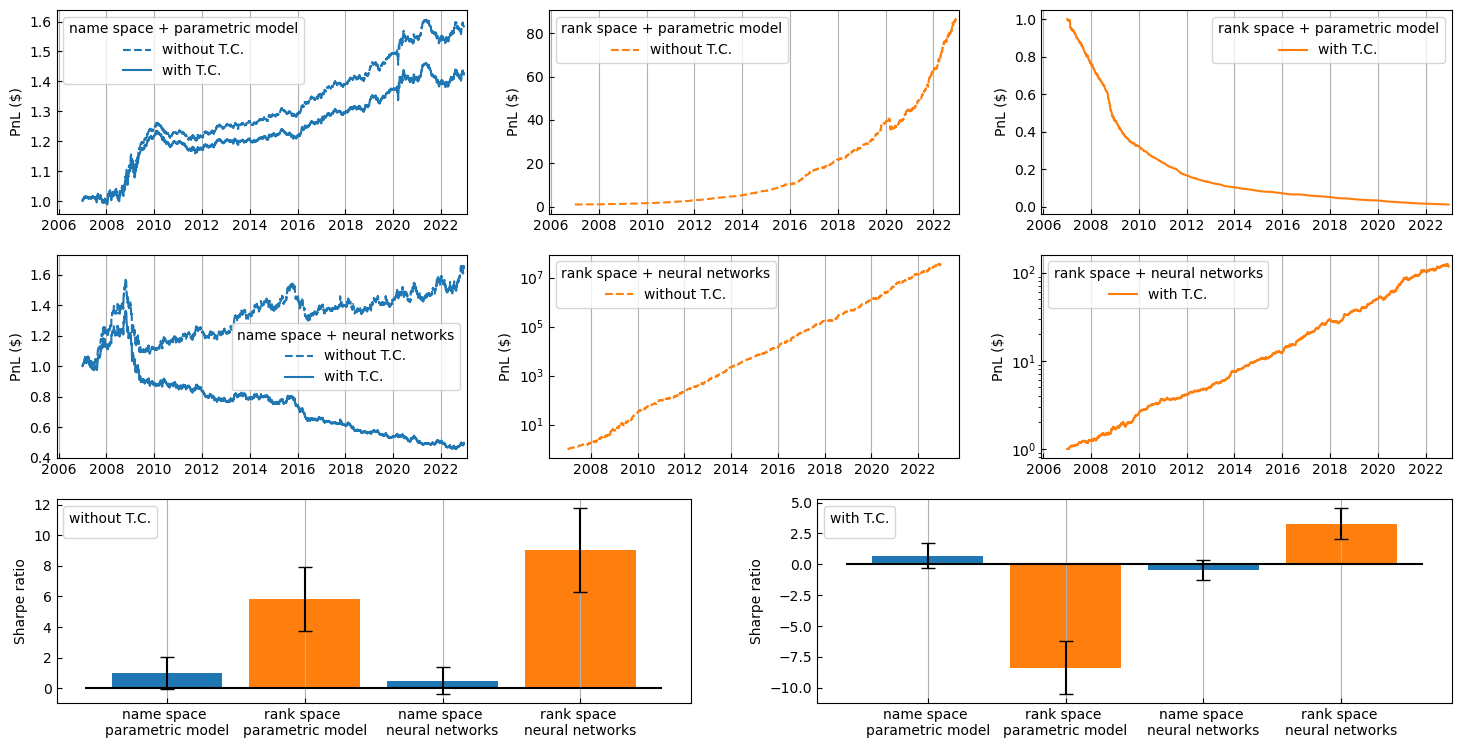

In [ ]:
plt.figure(figsize=(18, 9))
xlim = [datetime.datetime(2005,12,1), datetime.datetime(2023,1,31)]
plt.subplot(3,3,1)
factor_name = "PCA_name"
file_name = os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_without_transaction_cost.npz".format(factor_name))
result = np.load(file_name, allow_pickle=True)
time_hist = [datetime.datetime.fromtimestamp(j) for j in result["time_hist"]]
asset_hist = result["asset_hist"]; return_hist = result["return_hist"]
plt.plot(time_hist, asset_hist, label="without T.C.", color=color_cycle[0], linestyle="--")
file_name = os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_with_transaction_cost.npz".format(factor_name))
result = np.load(file_name, allow_pickle=True)
time_hist = [datetime.datetime.fromtimestamp(j) for j in result["time_hist"]]
asset_hist = result["asset_hist"]; return_hist = result["return_hist"]
plt.plot(time_hist, asset_hist, label="with T.C.", color=color_cycle[0])
plt.ylabel("PnL ($)"); plt.grid(axis="x")
plt.legend(title="name space + parametric model")
plt.tick_params(direction="in", axis="both")
plt.xlim(xlim)

plt.subplot(3,3,2)
factor_name = "PCA_rank_hybrid_Atlas_high_freq"
file_name = os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_without_transaction_cost.npz".format(factor_name))
result = np.load(file_name, allow_pickle=True)
time_hist = result["time_hist"]; asset_hist = result["asset_hist"]; return_hist = result["return_hist"]
time_hist = [datetime.datetime.fromtimestamp(j) for j in time_hist]
plt.plot(time_hist, asset_hist, label="without T.C.", color=color_cycle[1], linestyle="--")
plt.ylabel("PnL ($)"); plt.grid(axis="x")
plt.legend(title="rank space + parametric model")
plt.tick_params(direction="in", axis="both")
plt.xlim(xlim)

plt.subplot(3,3,3)
file_name = os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_with_transaction_cost.npz".format(factor_name))
result = np.load(file_name, allow_pickle=True)
time_hist = result["time_hist"]; asset_hist = result["asset_hist"]; return_hist = result["return_hist"]
time_hist = [datetime.datetime.fromtimestamp(j) for j in time_hist]
plt.plot(time_hist, asset_hist, label="with T.C.", color=color_cycle[1])
plt.ylabel("PnL ($)"); plt.grid(axis="x")
plt.legend(title="rank space + parametric model")
plt.tick_params(direction="in", axis="both")
plt.xlim(xlim)

plt.subplot(3,3,4)
factor_name = "PCA_name"
file_name = os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.npz".format(factor_name))
result = np.load(file_name, allow_pickle=True)
time_hist = result["time_hist"]; asset_hist = result["asset_hist"]; return_hist = result["return_hist"]
time_hist = [datetime.datetime.fromtimestamp(j) for j in time_hist]
plt.plot(time_hist, asset_hist, label="without T.C.", color=color_cycle[0], linestyle="--")
file_name = os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_with_transaction_cost.npz".format(factor_name))
result = np.load(file_name, allow_pickle=True)
time_hist = result["time_hist"]; asset_hist = result["asset_hist"]; return_hist = result["return_hist"]
time_hist = [datetime.datetime.fromtimestamp(j) for j in time_hist]
plt.plot(time_hist, asset_hist, label="with T.C.", color=color_cycle[0])
plt.ylabel("PnL ($)"); plt.grid(axis="x")
plt.tick_params(direction="in", axis="both")
plt.legend(title="name space + neural networks")
plt.xlim(xlim)

plt.subplot(3,3,5)
factor_name = "PCA_rank_hybrid_Atlas_high_freq"
f = open(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.pkl".format(factor_name)), "rb")
result = pickle.load(f); f.close()
time_axis_PnL = result["time_hist"]; asset_hist_R_rank = result["asset_hist_R_rank"]; asset_hist_R_name = result["asset_hist_R_name"]; transaction_cost_hist = result["transaction_cost_hist"]
plt.plot(time_axis_PnL, asset_hist_R_name, label="without T.C.", color=color_cycle[1], linestyle="--")
plt.ylabel("PnL ($)"); plt.grid(axis="x"); plt.legend()
plt.yscale("log"); plt.tick_params(direction="in", axis="both")
plt.legend(title="rank space + neural networks")
plt.tick_params(direction="in", axis="both")

plt.subplot(3,3,6)
factor_name = "PCA_rank_hybrid_Atlas_high_freq"
f = open(os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_with_transaction_cost.pkl".format(factor_name)), "rb")
result = pickle.load(f); f.close()
time_axis_PnL = result["time_hist"]; asset_hist_R_rank = result["asset_hist_R_rank"]; asset_hist_R_name = result["asset_hist_R_name"]; transaction_cost_hist = result["transaction_cost_hist"]
plt.plot(time_axis_PnL, asset_hist_R_name, label="with T.C.", color=color_cycle[1])
plt.ylabel("PnL ($)"); plt.grid(axis="x"); plt.legend()
plt.yscale("log"); plt.tick_params(direction="in", axis="both")
plt.tick_params(direction="in", axis="both")
plt.legend(title="rank space + neural networks")
plt.xlim(xlim)

'''
plt.subplot(3,2,7)
factor_name = "PCA_name"
file_name = os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_without_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name)
plt.plot([datetime.datetime(int(j),7,1) for j in df["year"]], df["sharp_ratio"], marker="o", color=color_cycle[0], linestyle="--", label="parametric model + without T.C.")
file_name = os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_with_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name)
plt.plot([datetime.datetime(int(j),7,1) for j in df["year"]], df["sharp_ratio"], marker="o", color=color_cycle[0], label="parametric + with T.C.")
file_name = os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name)
plt.plot([datetime.datetime(int(j),7,1) for j in df["year"]], df["sharp_ratio"], marker="*", color=color_cycle[0], linestyle="--", label="neural networks + without T.C.")
file_name = os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name)
plt.plot([datetime.datetime(int(j),7,1) for j in df["year"]], df["sharp_ratio"], marker="*", color=color_cycle[0], linestyle="--", label="neural networks + with T.C.")
plt.ylabel("sharp ratio"); plt.grid(axis="x")
plt.tick_params(direction="in", axis="both")
plt.legend(title="name space")
plt.xlim(xlim)

plt.subplot(3,3,8)
#plt.subplot(3,3,8, sharex=True, gridspec_kw={'height_ratios': [2, 1]})
factor_name = "PCA_rank_hybrid_Atlas_high_freq"
file_name = os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_without_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name)
plt.plot([datetime.datetime(int(j),7,1) for j in df["year"]], df["sharp_ratio"], marker="o", color=color_cycle[0], linestyle="--", label="parametric model + without T.C.")
file_name = os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name)
plt.plot([datetime.datetime(int(j),7,1) for j in df["year"]], df["sharp_ratio"], marker="o", color=color_cycle[0], linestyle="--", label="neural network + without T.C.")

plt.grid(axis="x")
plt.tick_params(direction="in", axis="both")
plt.legend(title="rank space")
plt.xlim(xlim)

plt.subplot(3,3,9)
file_name = os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_with_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name)
plt.plot([datetime.datetime(int(j),7,1) for j in df["year"]], df["sharp_ratio"], marker="o", color=color_cycle[0], label="parametric model + with T.C.")
file_name = os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_with_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name)
plt.plot([datetime.datetime(int(j),7,1) for j in df["year"]], df["sharp_ratio"], marker="*", color=color_cycle[0], label="neural networks + with T.C.")
plt.grid(axis="x")
plt.tick_params(direction="in", axis="both")
plt.legend(title="rank space")
plt.xlim(xlim)
'''

plt.subplot(3,2,5)
factor_name = "PCA_name"
file_name = os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_without_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name); sharp_ratio = df["sharp_ratio"]
plt.bar(["name space \nparametric model"], [np.mean(sharp_ratio)], yerr=[np.std(sharp_ratio)], capsize = 5, color=color_cycle[0])

factor_name = "PCA_rank_hybrid_Atlas_high_freq"
file_name = os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_without_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name); sharp_ratio = df["sharp_ratio"]
plt.bar(["rank space \nparametric model"], [np.mean(sharp_ratio)], yerr=[np.std(sharp_ratio)], capsize = 5, color=color_cycle[1])

factor_name = "PCA_name"
file_name = os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name); sharp_ratio = df["sharp_ratio"]
plt.bar(["name space \nneural networks"], [np.mean(sharp_ratio)], yerr=[np.std(sharp_ratio)], capsize = 5, color=color_cycle[0])

factor_name = "PCA_rank_hybrid_Atlas_high_freq"
file_name = os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_without_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name); sharp_ratio = df["sharp_ratio"]
plt.bar(["rank space \nneural networks"], [np.mean(sharp_ratio)], yerr=[np.std(sharp_ratio)], capsize = 5, color=color_cycle[1])
plt.ylabel("Sharpe ratio"); plt.grid(axis="x")
plt.tick_params(direction="in", axis="both")
plt.hlines(0, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], color="black")
plt.legend(title="without T.C.", loc="upper left")

plt.subplot(3,2,6)
factor_name = "PCA_name"
file_name = os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_with_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name); sharp_ratio = df["sharp_ratio"]
plt.bar(["name space \nparametric model"], [np.mean(sharp_ratio)], yerr=[np.std(sharp_ratio)], capsize = 5, color=color_cycle[0])

factor_name = "PCA_rank_hybrid_Atlas_high_freq"
file_name = os.path.join(os.getcwd(), "PnL_{}-OU_process-OU_process_with_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name); sharp_ratio = df["sharp_ratio"]
plt.bar(["rank space \nparametric model"], [np.mean(sharp_ratio)], yerr=[np.std(sharp_ratio)], capsize = 5, color=color_cycle[1])

factor_name = "PCA_name"
file_name = os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_with_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name); sharp_ratio = df["sharp_ratio"]
plt.bar(["name space \nneural networks"], [np.mean(sharp_ratio)], yerr=[np.std(sharp_ratio)], capsize = 5, color=color_cycle[0])

factor_name = "PCA_rank_hybrid_Atlas_high_freq"
file_name = os.path.join(os.getcwd(), "PnL_{}-CNN_transformer_with_transaction_cost.csv".format(factor_name))
df = pd.read_csv(file_name); sharp_ratio = df["sharp_ratio"]
plt.bar(["rank space \nneural networks"], [np.mean(sharp_ratio)], yerr=[np.std(sharp_ratio)], capsize = 5, color=color_cycle[1])
plt.ylabel("Sharpe ratio"); plt.grid(axis="x")
plt.tick_params(direction="in", axis="both")
plt.hlines(0, plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], color="black")
plt.legend(title="with T.C.", loc="upper left")
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "PnL_summary.pdf"), dpi=300)
